In [13]:
pip install ragas==0.1.9 -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd

In [3]:
os.chdir('../../')
os.getcwd()

'/teamspace/studios/this_studio/Legal_Expert_Contract_Advisor_Using_Precision_RAG'

In [42]:
import yaml

def load_config():
    with open("data/evaluation/raptor.json", "r") as f:
        return yaml.safe_load(f)
qa = load_config()

In [3]:
import yaml

def load_config():
    with open("data/evaluation/robinson.json", "r") as f:
        return yaml.safe_load(f)
qa = load_config()

In [4]:
qa

[{'question': 'Who are the parties to the Agreement and what are their defined names?',
  'answer': 'Cloud Investments Ltd. (“Company”) and Jack Robinson (“Advisor”).'},
 {'question': 'What is the termination notice?',
  'answer': 'According to section 4: 14 days for convenience by both parties. The Company may terminate without notice if the Advisor refuses or cannot perform the Services or is in breach of any provision of this Agreement.'},
 {'question': 'What are the payments to the Advisor under the Agreement?',
  'answer': 'According to section 6: 1. Fees of $9 per hour up to a monthly limit of $1500 2. Workspace expense of $100 per month 3. Other reasonable and actual expenses if approved by the company in writing and in advance.'},
 {'question': 'Can the Agreement or any of its obligations be assigned?',
  'answer': '1. Under section 1.1 the Advisor can’t assign any of his obligations without the prior written consent of the Company 2. Under section 9 the Advisor may not assign 

In [5]:
question = [q['question'] for q in qa]
ground_truth = [q['answer'] for q in qa]

In [6]:
# get first 3 question
three_question = question[:3]

In [7]:
three_ground_truth = ground_truth[:3]

In [12]:
three_question

['Who are the parties to the Agreement and what are their defined names?',
 'What is the termination notice?',
 'What are the payments to the Advisor under the Agreement?']

In [13]:
three_ground_truth

['Cloud Investments Ltd. (“Company”) and Jack Robinson (“Advisor”).',
 'According to section 4: 14 days for convenience by both parties. The Company may terminate without notice if the Advisor refuses or cannot perform the Services or is in breach of any provision of this Agreement.',
 'According to section 6: 1. Fees of $9 per hour up to a monthly limit of $1500 2. Workspace expense of $100 per month 3. Other reasonable and actual expenses if approved by the company in writing and in advance.']

In [14]:
import requests

url = "http://127.0.0.1:8000/qa/RagFusion_600_50_semantic_hybrid_gpt35_DataRobinson"
answers = []
contexts = []
for q in three_question:
    data = {
        "query": q
    }
    response = requests.post(url, json=data)

    print(response.json()['response'])

    answers.append(response.json()['response'])
    contexts.append(response.json()['context'])

The parties to the Agreement are not explicitly mentioned in the provided context.
The termination notice is fourteen (14) days' prior written notice.
The payments to the Advisor under the Agreement consist of 60% salary payments and 40% payment by the Company for all other Advisor statutory rights and benefits as an employee of the Company throughout the Term.


In [15]:
answers

['The parties to the Agreement are not explicitly mentioned in the provided context.',
 "The termination notice is fourteen (14) days' prior written notice.",
 'The payments to the Advisor under the Agreement consist of 60% salary payments and 40% payment by the Company for all other Advisor statutory rights and benefits as an employee of the Company throughout the Term.']

In [16]:
array_contexts = [[con] for con in contexts]

In [17]:
array_contexts

[['Each of the parties acknowledges and agrees that the other parties would be damaged irreparably in the event any of the provisions of this Agreement are not performed in accordance with their specific terms or otherwise are breached or violated. Accordingly, each of the parties agrees that, without posting a bond or other undertaking, the other parties will be entitled to an injunction or injunctions to prevent breaches or violations of the provisions of this Agreement and to enforce specifically this Agreement and the terms and provisions hereof in any Action instituted in any court of Israel or of the United States or any state thereof having jurisdiction over the parties and the matter in addition to any other remedy to which it may be entitled, at law or in equity. Each party further agrees that, in the event of any action for specific performance in respect of such breach or violation, it will not assert that the defense that a remedy at law would be adequate. Waiver of Jury Tr

In [8]:
import json
# incase kernel restart reun this to save the context and answer as a json file

# save the context and answer as a json file
with open("context.json", "w") as f:
    json.dump({"context": contexts, "answer": answers}, f)

# read the json file
with open("context.json", "r") as f:
    context = json.load(f)

contexts = context['context']
answers = context['answer']

In [11]:
len(answers), len(contexts), len(question), len(ground_truth)

(14, 14, 14, 14)

In [18]:
from datasets import Dataset
# To dict
data = {
    "question": three_question,
    "answer": answers,
    "contexts": array_contexts,
    "ground_truth": three_ground_truth
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

In [108]:
dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 3
})

In [109]:
from ragas import evaluate
from langchain_openai import ChatOpenAI
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness
)

result = evaluate(
    dataset = dataset, 
    llm = ChatOpenAI(temperature=0), # use gpt-4o to increase context window, but has high cost
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
        answer_correctness,
    ],
)

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

In [110]:
df = result.to_pandas()

In [111]:
df.to_csv("data/evaluation/no_translation_500_50_semantic_hybrid_gpt35_DataRobinson.csv")

In [112]:
no_translation_500_50_semantic_hybrid_gpt35 = pd.read_csv("data/evaluation/no_translation_500_50_semantic_hybrid_gpt35_DataRobinson.csv", index_col=0)
no_translation_500_50_semantic_hybrid_gpt35

,question,answer,contexts,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy,answer_correctness
0,Who are the parties to the Agreement and what ...,The parties to the Agreement are not explicitl...,['Each of the parties acknowledges and agrees ...,Cloud Investments Ltd. (“Company”) and Jack Ro...,1.0,1.0,1.0,0.000000,0.186978
1,What is the termination notice?,The termination notice is fourteen (14) days' ...,"['Termination: Either party, at any given time...",According to section 4: 14 days for convenienc...,1.0,0.5,1.0,0.890201,0.218334
2,What are the payments to the Advisor under the...,The payments to the Advisor under the Agreemen...,"[""Without derogating from the above, if it is ...",According to section 6: 1. Fees of $9 per hour...,0.0,0.0,1.0,0.979249,0.195499


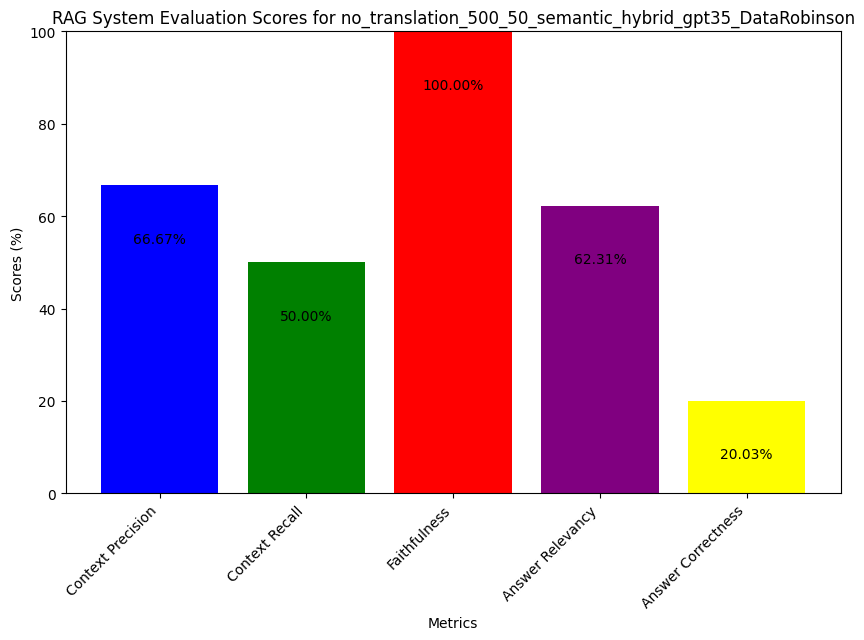

In [115]:
# calculate the average score of context precision per total score

context_precision_score = no_translation_500_50_semantic_hybrid_gpt35['context_precision'].sum() / no_translation_500_50_semantic_hybrid_gpt35['context_precision'].count() * 100
context_recall_score = no_translation_500_50_semantic_hybrid_gpt35['context_recall'].sum() / no_translation_500_50_semantic_hybrid_gpt35['context_recall'].count() * 100
faithfulness_score = no_translation_500_50_semantic_hybrid_gpt35['faithfulness'].sum() / no_translation_500_50_semantic_hybrid_gpt35['faithfulness'].count() * 100
answer_relevancy_score = no_translation_500_50_semantic_hybrid_gpt35['answer_relevancy'].sum() / no_translation_500_50_semantic_hybrid_gpt35['answer_relevancy'].count() * 100
answer_correctness_score = no_translation_500_50_semantic_hybrid_gpt35['answer_correctness'].sum() / no_translation_500_50_semantic_hybrid_gpt35['answer_correctness'].count() * 100

avg_total_score = (context_precision_score + context_recall_score + faithfulness_score + answer_relevancy_score) / 4

avg_context_score = (context_precision_score + context_recall_score) / 2

avg_generate_score = (faithfulness_score + answer_relevancy_score) / 2

import matplotlib.pyplot as plt

# Visualization
labels = ['Context Precision', 'Context Recall', 'Faithfulness', 'Answer Relevancy', 'Answer Correctness']
scores = [context_precision_score, context_recall_score, faithfulness_score, answer_relevancy_score, answer_correctness_score]

plt.figure(figsize=(10, 6))
plt.bar(labels, scores, color=['blue', 'green', 'red', 'purple', 'yellow'])
# tilt the x axis lables to 45 degrees 
plt.xticks(rotation=45, ha='right')
plt.xlabel('Metrics')
plt.ylabel('Scores (%)')
plt.title('RAG System Evaluation Scores for no_translation_500_50_semantic_hybrid_gpt35_DataRobinson')
plt.ylim(0, 100)

# Annotate bars with scores
for i, score in enumerate(scores):
    plt.text(i, score - 10, f'{score:.2f}%', ha='center', va='top')

plt.show()

In [4]:
RaptorIndexing_500_50_semantic_hybrid_gpt35_DataRobinson = pd.read_csv("data/evaluation/RaptorIndexing_500_50_semantic_hybrid_gpt35_DataRobinson.csv", index_col=0)
pd.set_option('display.max_colwidth', None)
RaptorIndexing_500_50_semantic_hybrid_gpt35_DataRobinson
# make the question and answer columns readable

question  \
0  Who are the parties to the Agreement and what are their defined names?   
1                                         What is the termination notice?   
2               What are the payments to the Advisor under the Agreement?   

                                                                                                                                                                                                                                                                                                                                                                             answer  \
0                                                                                                                                                                                                                                       The parties to the Agreement are Cloud Investments Ltd (referred to as the "Company") and Mr. Jack Robinson (referred to as the "Advisor").   
1  The termination notice period in the agreement is fourteen (14) days for either party to terminate the Agreement for any reason with or without cause. However, the Company has the right to terminate the Agreement immediately and without prior notice if the Advisor refuses to perform services, is unable to perform services, or breaches any provision of the Agreement.   
2         The Company shall pay the Advisor hourly fees at a rate of USD 9 per Billable Hour, limited to a maximum of USD 1,500 per month. The Advisor will also receive USD 100 per month to finance a workspace if they hire a professional workspace. 40% of payments will constitute payment for all other Advisor statutory rights and benefits as an employee of the Company.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

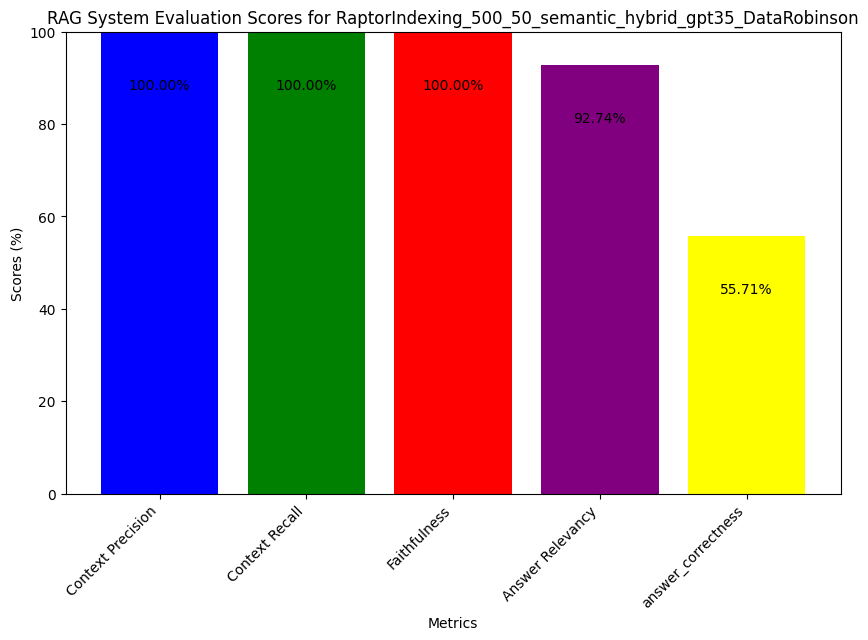

In [100]:
# calculate the average score of context precision per total score

context_precision_score = RaptorIndexing_500_50_semantic_hybrid_gpt35_DataRobinson['context_precision'].sum() / RaptorIndexing_500_50_semantic_hybrid_gpt35_DataRobinson['context_precision'].count() * 100
context_recall_score = RaptorIndexing_500_50_semantic_hybrid_gpt35_DataRobinson['context_recall'].sum() / RaptorIndexing_500_50_semantic_hybrid_gpt35_DataRobinson['context_recall'].count() * 100
faithfulness_score = RaptorIndexing_500_50_semantic_hybrid_gpt35_DataRobinson['faithfulness'].sum() / RaptorIndexing_500_50_semantic_hybrid_gpt35_DataRobinson['faithfulness'].count() * 100
answer_relevancy_score = RaptorIndexing_500_50_semantic_hybrid_gpt35_DataRobinson['answer_relevancy'].sum() / RaptorIndexing_500_50_semantic_hybrid_gpt35_DataRobinson['answer_relevancy'].count() * 100
answer_correctness_score = RaptorIndexing_500_50_semantic_hybrid_gpt35_DataRobinson['answer_correctness'].sum() / RaptorIndexing_500_50_semantic_hybrid_gpt35_DataRobinson['answer_correctness'].count() * 100

avg_total_score = (context_precision_score + context_recall_score + faithfulness_score + answer_relevancy_score) / 4

avg_context_score = (context_precision_score + context_recall_score) / 2

avg_generate_score = (faithfulness_score + answer_relevancy_score) / 2

import matplotlib.pyplot as plt

# Visualization
labels = ['Context Precision', 'Context Recall', 'Faithfulness', 'Answer Relevancy', 'answer_correctness']
scores = [context_precision_score, context_recall_score, faithfulness_score, answer_relevancy_score, answer_correctness_score]

plt.figure(figsize=(10, 6))
plt.bar(labels, scores, color=['blue', 'green', 'red', 'purple', 'yellow'])
# tilt the x axis lables to 45 degrees 
plt.xticks(rotation=45, ha='right')
plt.xlabel('Metrics')
plt.ylabel('Scores (%)')
plt.title('RAG System Evaluation Scores for RaptorIndexing_500_50_semantic_hybrid_gpt35_DataRobinson')
plt.ylim(0, 100)

# Annotate bars with scores
for i, score in enumerate(scores):
    plt.text(i, score - 10, f'{score:.2f}%', ha='center', va='top')  # Adding padding by increasing the y-coordinate

plt.show()

In [94]:
RagFusion_500_50_semantic_hybrid_gpt35_DataRobinson = pd.read_csv("data/evaluation/RagFusion_500_50_semantic_hybrid_gpt35_DataRobinson.csv", index_col=0)
RagFusion_500_50_semantic_hybrid_gpt35_DataRobinson

,question,answer,contexts,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy,answer_correctness
0,Who are the parties to the Agreement and what ...,The parties to the Agreement are not explicitl...,['IN WITNESS WHEREOF the parties have executed...,Cloud Investments Ltd. (“Company”) and Jack Ro...,1.0,1.000000,0.0,0.000000,0.185127
1,What is the termination notice?,The termination notice is fourteen (14) days' ...,"['Termination: Either party, at any given time...",According to section 4: 14 days for convenienc...,1.0,0.500000,1.0,0.881419,0.218334
2,What are the payments to the Advisor under the...,The payments to the Advisor under the Agreemen...,"['Without derogating from the above, if it is ...",According to section 6: 1. Fees of $9 per hour...,1.0,0.333333,1.0,0.964736,0.195499


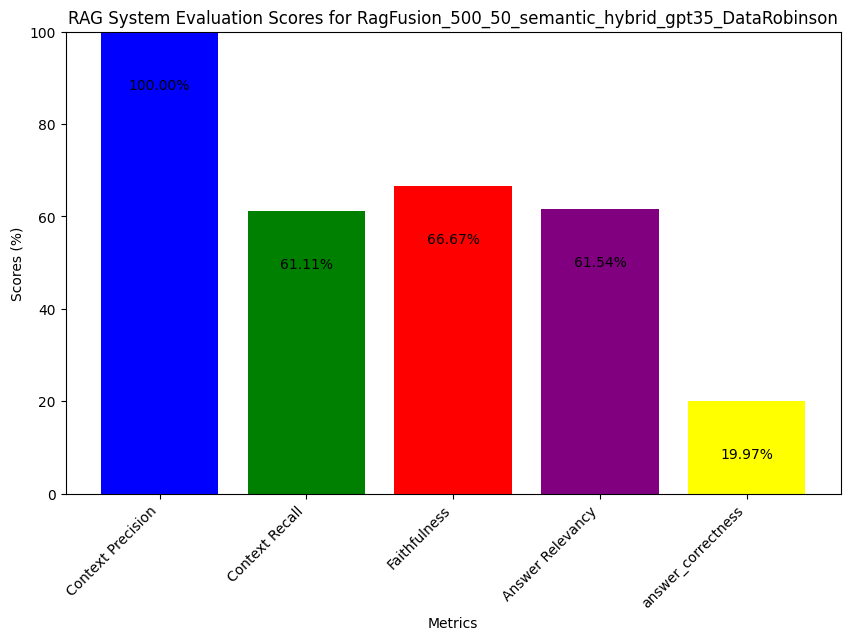

In [99]:
# calculate the average score of context precision per total score

context_precision_score = RagFusion_500_50_semantic_hybrid_gpt35_DataRobinson['context_precision'].sum() / RagFusion_500_50_semantic_hybrid_gpt35_DataRobinson['context_precision'].count() * 100
context_recall_score = RagFusion_500_50_semantic_hybrid_gpt35_DataRobinson['context_recall'].sum() / RagFusion_500_50_semantic_hybrid_gpt35_DataRobinson['context_recall'].count() * 100
faithfulness_score = RagFusion_500_50_semantic_hybrid_gpt35_DataRobinson['faithfulness'].sum() / RagFusion_500_50_semantic_hybrid_gpt35_DataRobinson['faithfulness'].count() * 100
answer_relevancy_score = RagFusion_500_50_semantic_hybrid_gpt35_DataRobinson['answer_relevancy'].sum() / RagFusion_500_50_semantic_hybrid_gpt35_DataRobinson['answer_relevancy'].count() * 100
answer_correctness_score = RagFusion_500_50_semantic_hybrid_gpt35_DataRobinson['answer_correctness'].sum() / RagFusion_500_50_semantic_hybrid_gpt35_DataRobinson['answer_correctness'].count() * 100

avg_total_score = (context_precision_score + context_recall_score + faithfulness_score + answer_relevancy_score) / 4

avg_context_score = (context_precision_score + context_recall_score) / 2

avg_generate_score = (faithfulness_score + answer_relevancy_score) / 2

import matplotlib.pyplot as plt

# Visualization
labels = ['Context Precision', 'Context Recall', 'Faithfulness', 'Answer Relevancy', 'answer_correctness']
scores = [context_precision_score, context_recall_score, faithfulness_score, answer_relevancy_score, answer_correctness_score]

plt.figure(figsize=(10, 6))
plt.bar(labels, scores, color=['blue', 'green', 'red', 'purple', 'yellow'])
# tilt the x axis lables to 45 degrees 
plt.xticks(rotation=45, ha='right')
plt.xlabel('Metrics')
plt.ylabel('Scores (%)')
plt.title('RAG System Evaluation Scores for RagFusion_500_50_semantic_hybrid_gpt35_DataRobinson')
plt.ylim(0, 100)

# Annotate bars with scores
for i, score in enumerate(scores):
    plt.text(i, score - 10, f'{score:.2f}%', ha='center', va='top')  # Adding padding by increasing the y-coordinate

plt.show()